# **Classify Waste Products usign Transfer learning**

The necessary libraries are imported

In [1]:
import numpy as np
import datetime
import os
import random, shutil
import glob
#import skillsnetwork

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from matplotlib.image import imread

from os import makedirs,listdir
from shutil import copyfile
from random import seed
from random import random
import keras 
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import opendatasets as od

sns.set_context('notebook')
sns.set_style('white')

2.11.0


We define some configuration variables

In [2]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3) #RGB
labels = ['O', 'R']
seed = 10
checkpoint_path='ORnet.h5'

Images are loaded using ImageGeneratorClass

In [3]:
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

Flow_From_Directory is used to load images in batch

In [4]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'training'
)

Found 5810 images belonging to 2 classes.


In [5]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'validation'
)

Found 1452 images belonging to 2 classes.


In [6]:
test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    classes = labels,
    class_mode='binary',
    seed = seed,
    batch_size = batch_size, 
    shuffle = True,
    target_size=(img_rows, img_rows)
)

Found 828 images belonging to 2 classes.


Some of the images are shown

Labels: ['O\\O_10', 'O\\O_10', 'O\\O_10', 'O\\O_10', 'O\\O_10']


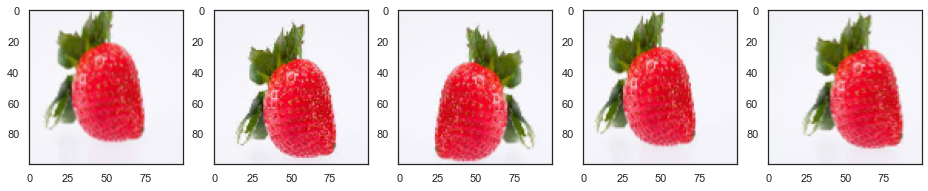

In [7]:
IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[3].split('.')[0].strip() for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]

We load the model

In [8]:
from keras.applications import vgg16
input_shape = (150, 150, 3)

vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

58889256/58889256 [==============================] - 182s 3us/step


In [9]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

Freeze the basemodel to not be retrained

In [10]:
basemodel.trainable = False
for layer in basemodel.layers: layer.trainable = False

A new model is created on top of the old basemodel

In [11]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [12]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8192)              14714688  
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 19,172,673
Trainable params: 4,457,985
Non

The new model is compiled

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

Early stopping is used to avoid overtraining

In [14]:
from keras.callbacks import LearningRateScheduler
checkpoint_path='O_R_tlearn_image_augm_cnn_vgg16.h5'

class LossHistory_(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(len(self.losses)))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'loss', 
                    patience = 5, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_, keras_callbacks]

Fit and train the new model

In [15]:
extract_feat_model = model.fit(train_generator, 
                              steps_per_epoch=10, 
                              epochs=5,
                              validation_data=val_generator, 
                              validation_steps=10, 
                              verbose=1,
                              callbacks = callbacks_list_)  

Epoch 1/5
10/10 [==============================] - 139s 14s/step - loss: 80477.3906 - accuracy: 0.5125 - val_loss: 161.0149 - val_accuracy: 0.5437 - lr: 0.1000
Epoch 2/5
10/10 [==============================] - 146s 15s/step - loss: 256.8231 - accuracy: 0.6781 - val_loss: 560.7124 - val_accuracy: 0.4187 - lr: 0.0905
Epoch 3/5
10/10 [==============================] - 142s 15s/step - loss: 121.5133 - accuracy: 0.6219 - val_loss: 148.2871 - val_accuracy: 0.4969 - lr: 0.0819
Epoch 4/5
10/10 [==============================] - 131s 14s/step - loss: 19.4074 - accuracy: 0.6656 - val_loss: 2.1518 - val_accuracy: 0.6750 - lr: 0.0741
Epoch 5/5
10/10 [==============================] - 136s 14s/step - loss: 2.2434 - accuracy: 0.6375 - val_loss: 0.6530 - val_accuracy: 0.6906 - lr: 0.0670


Fine Tunning

In [16]:
[layer.name for layer in basemodel.layers]

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten']

In [17]:
basemodel.trainable = True
set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

We create a new model

In [18]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_image_augm_fine_tune_vgg16.h5'

loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'loss', 
                    patience = 5, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_, keras_callbacks]

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])
              
fine_tune_model = model.fit(train_generator, 
                    steps_per_epoch=10, 
                    epochs=5,
                    callbacks = callbacks_list_,   
                    validation_data=val_generator, 
                    validation_steps=10, 
                    verbose=1)   

Epoch 1/5
10/10 [==============================] - 224s 23s/step - loss: 45017546468590878720.0000 - accuracy: 0.4938 - val_loss: 3631179.2500 - val_accuracy: 0.4406 - lr: 0.1000
Epoch 2/5
10/10 [==============================] - 195s 20s/step - loss: 455138.4375 - accuracy: 0.5063 - val_loss: 30733.7598 - val_accuracy: 0.5875 - lr: 0.0905
Epoch 3/5
10/10 [==============================] - 219s 23s/step - loss: 31725.8379 - accuracy: 0.5250 - val_loss: 19789.1914 - val_accuracy: 0.6094 - lr: 0.0819
Epoch 4/5
10/10 [==============================] - 223s 23s/step - loss: 15249.5127 - accuracy: 0.4906 - val_loss: 12275.5020 - val_accuracy: 0.5750 - lr: 0.0741
Epoch 5/5
10/10 [==============================] - 203s 21s/step - loss: 10234.8340 - accuracy: 0.4750 - val_loss: 1837.7927 - val_accuracy: 0.5781 - lr: 0.0670


Load saved models

In [19]:
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_image_augm_cnn_vgg16.h5')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_image_augm_fine_tune_vgg16.h5')

We load the test set

In [20]:
from sklearn.utils import shuffle
IMG_DIM = (150, 150)
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O + test_files_R
test_files = shuffle(test_files)[0:50]
test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[3].split('.')[0].strip() for fn in test_files]
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

In [21]:
class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]
test_labels_enc = class2num_lt(test_labels)

In [22]:
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

In [23]:
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

In [24]:
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))

Extract Features Model
              precision    recall  f1-score   support

           O       0.00      0.00      0.00       0.0
   O\O_10053       0.00      0.00      0.00       1.0
   O\O_10276       0.00      0.00      0.00       1.0
    O\O_1091       0.00      0.00      0.00       1.0
   O\O_11925       0.00      0.00      0.00       1.0
    O\O_2224       0.00      0.00      0.00       1.0
    O\O_2487       0.00      0.00      0.00       1.0
    O\O_2553       0.00      0.00      0.00       1.0
    O\O_2596       0.00      0.00      0.00       1.0
    O\O_3372       0.00      0.00      0.00       1.0
    O\O_3716       0.00      0.00      0.00       1.0
     O\O_389       0.00      0.00      0.00       1.0
    O\O_3947       0.00      0.00      0.00       1.0
    O\O_4279       0.00      0.00      0.00       1.0
     O\O_441       0.00      0.00      0.00       1.0
    O\O_4417       0.00      0.00      0.00       1.0
    O\O_4690       0.00      0.00      0.00       1.0
    

C:\Users\laptop\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\laptop\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\laptop\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\laptop\anaconda3\lib\site-packages\sklearn\metrics\

Here the prediction is made with a new image never seen

['O']

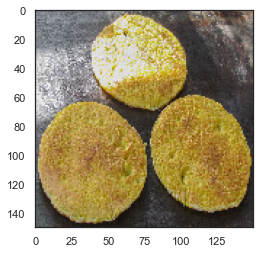

In [26]:
# Load the original image and resize it to IMG_DIM
orig_im = tf.keras.preprocessing.image.load_img('Organic/Cachapa.jpg', target_size=IMG_DIM)
plt.imshow(orig_im)

# Convert to array and rescale the image values
custom_im = tf.keras.preprocessing.image.img_to_array(orig_im)
custom_im_scaled = custom_im.astype('float32')
custom_im_scaled /= 255

# Predict the waste category
num2class_lt(extract_feat_model.predict(custom_im_scaled.reshape((1,IMG_DIM[0], IMG_DIM[1],3)), verbose=0))